# Evaluting The Model

In this notebook, we will test the model we have trained in the previous notebook. We will use the a longer test set to evaluate the model. 

In [1]:
import sys
import os
import glob
import pandas as pd
import numpy as np

head, _ = os.path.split(sys.path[0])
sys.path[0] = head

import src.utils as utils

We will start by gathering the test data from the test set. We decided to go for the data from 02/09/2021 to 29/03/2021, we should note that some days are missing inside this range, but we will use the data from the days that we have.  
First we need the people count data from the test set, that was already reviewed to check the validity of the measurements made by the RGB camera.

In [2]:
path = '../data/testing_peoplecount/'
files = [f for f in glob.glob(path + "**/*.json", recursive=True)]

Then we downloaded the corresponding data of CO2 measurements from our database. We had to download it part by part, because the database doesn't allow downloading large data.  

In [3]:
df_co2 = pd.read_csv("../data/testing/VTEC-Device_MS-IPac67b205b3df_2021-02-09_00_00_00-2021-02-23_00_00_00.csv", sep=";")
df_temp = pd.read_csv("../data/testing/VTEC-Device_MS-IPac67b205b3df_2021-02-23_00_00_00-2021-03-05_00_00_00.csv", sep=";")
df_temp_2 = pd.read_csv("../data/testing/VTEC-Device_MS-IPac67b205b3df_2021-03-05_00_00_00-2021-03-19_00_00_00.csv", sep=";")
df_temp_3 = pd.read_csv("../data/testing/VTEC-Device_MS-IPac67b205b3df_2021-03-19_00_00_00-2021-03-30_00_00_00.csv", sep=";")

# merge the 4 dataframes into one, one after the other
df_co2 = pd.concat([df_co2, df_temp, df_temp_2, df_temp_3], ignore_index=True)

C:\Users\elmah\AppData\Local\Temp\ipykernel_10732\1342990659.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_co2 = pd.read_csv("../data/testing/VTEC-Device_MS-IPac67b205b3df_2021-02-09_00_00_00-2021-02-23_00_00_00.csv", sep=";")
C:\Users\elmah\AppData\Local\Temp\ipykernel_10732\1342990659.py:3: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp_2 = pd.read_csv("../data/testing/VTEC-Device_MS-IPac67b205b3df_2021-03-05_00_00_00-2021-03-19_00_00_00.csv", sep=";")
C:\Users\elmah\AppData\Local\Temp\ipykernel_10732\1342990659.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp_3 = pd.read_csv("../data/testing/VTEC-Device_MS-IPac67b205b3df_2021-03-19_00_00_00-2021-03-30_00_00_00.csv", sep=";")


In [4]:
df_test = utils.create_final_df(files, df_co2)
df_test

time  peoplecount_rgb    co2  occupancy  time_hours
1     2021-02-09 00:01:15.167                0  408.0          0           0
8     2021-02-09 00:05:17.959                0  429.0          0           0
9     2021-02-09 00:06:16.140                0  407.0          0           0
12    2021-02-09 00:08:15.780                0  410.0          0           0
13    2021-02-09 00:08:27.000                0  410.0          0           0
...                       ...              ...    ...        ...         ...
56305 2021-03-29 22:53:02.193                0  418.0          0          22
56306 2021-03-29 22:54:00.040                0  419.0          0          22
56307 2021-03-29 22:55:01.748                0  430.0          0          22
56309 2021-03-29 22:57:01.398                0  447.0          0          22
56310 2021-03-29 22:57:59.689                0  414.0          0          22

[28585 rows x 5 columns]

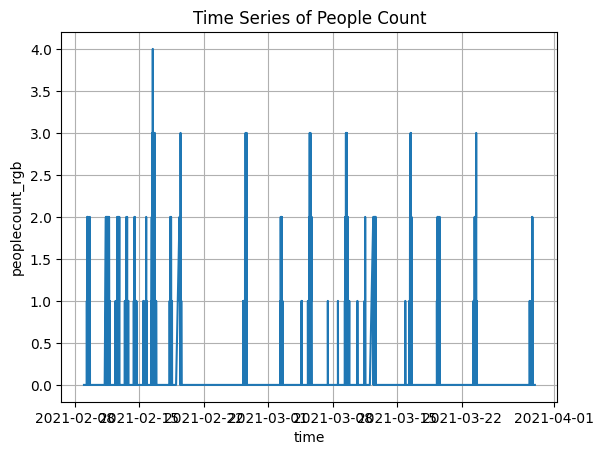

In [5]:
utils.plot_time_series(df_test,'peoplecount_rgb','People Count',matplotlib = False)
utils.plot_time_series(df_test, 'peoplecount_rgb','People Count',matplotlib = True) # for github

In [6]:
utils.plot_time_series(df_test,'co2','CO2',matplotlib = False)

We'll run the STD method to get the trend of the CO2 data

In [7]:
import src.std as std

trend_co2, trend_occupancy, seasonal_co2, seasonal_occupancy, reminder_feature_co2, reminder_feature_occupancy = std.decompose_time_series(df_test)

In [18]:
df_test['trend_co2'] = trend_co2

The accuracy of the model is:  0.8371523526324995


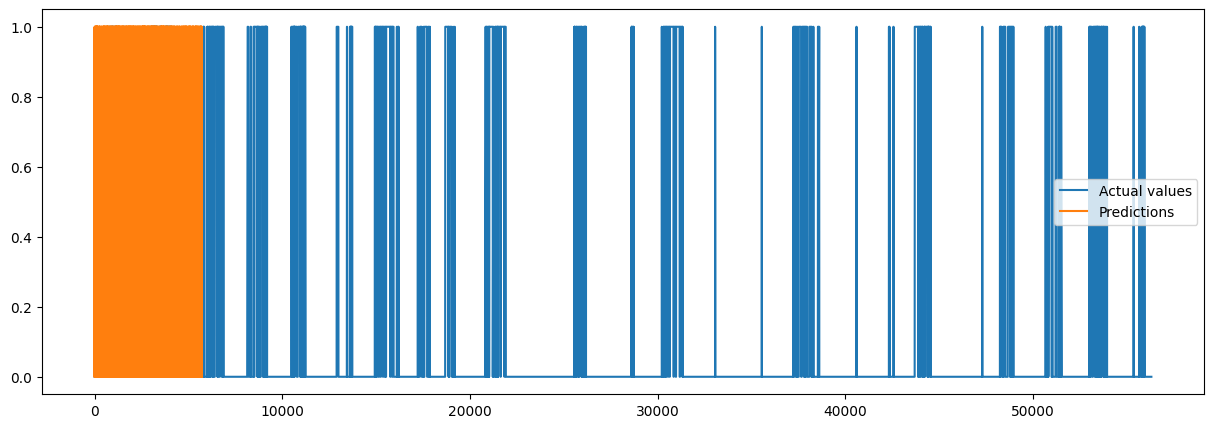

In [19]:
# test knn algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into train and test df['time'] and df['co2'], df['peoplecount_rgb']
X_train, X_test, y_train, y_test = train_test_split(df_test[['time_hours', 'trend_co2']], df_test['occupancy'], test_size=0.2, random_state=42)

# create the model
model_1 = KNeighborsClassifier(n_neighbors=3)

# fit the model
model_1.fit(X_train, y_train)

# make predictions
y_pred = model_1.predict(X_test)

# calculate the accuracy
print('The accuracy of the model is: ', accuracy_score(y_test, y_pred))

# plot the predictions and the actual values
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test['time'], y=df_test['occupancy'], mode='lines', name='Actual values'))
fig.add_trace(go.Scatter(x=df_test['time'], y=y_pred, mode='lines', name='Predictions'))
fig.show()

# also use matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df_test['occupancy'], label='Actual values')
plt.plot(y_pred, label='Predictions')

plt.legend()
plt.show()